In [1]:
from unsloth import FastLanguageModel
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    DataCollatorForSeq2Seq,
    TextStreamer,
)
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from accelerate import infer_auto_device_map
import random
import numpy as np
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


nvidia-smi: line 14: /usr/bin/data-set: No such file or directory


🦥 Unsloth Zoo will now patch everything to make training faster!


nvidia-smi: line 14: /usr/bin/data-set: No such file or directory
nvidia-smi: line 14: /usr/bin/data-set: No such file or directory


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# 1. Configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True 
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = "Create a function to compute the sum of a list of integers."
input = "[1, 2, 3, 4, 5]"

In [4]:
base_model = "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/Qwen2.5-0.5B"

# max_memory={0: "1GiB", 1: "38GiB"}

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    # load_in_8bit=True,
    # torch_dtype=torch.float16,
    device_map = "auto", 
    # max_memory=max_memory,
)
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    device_map = "auto", 
    # max_memory=max_memory,
)

In [5]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        instruction, # instruction
        input, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to(0)

# text_streamer = TextStreamer(tokenizer)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 100)

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**inputs, max_new_tokens=100)[0], skip_special_tokens=True))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Create a function to compute the sum of a list of integers.

### Input:
[1, 2, 3, 4, 5]

### Response:
Here is a Python function that computes the sum of a list of integers:

```python
def sum_list(numbers):
    total = 0
    for num in numbers:
        total += num
    return total
```

This function takes a list of integers as input and initializes a variable `total` to 0. It then iterates over each number in the list and adds it to the `total` variable. Finally, it returns the computed sum.


In [6]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
print(EOS_TOKEN)
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

<|endoftext|>


In [7]:
dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Using the latest cached version of the dataset since iamtarun/python_code_instructions_18k_alpaca couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/iamtarun___python_code_instructions_18k_alpaca/default/0.0.0/7cae181e29701a8663a07a3ea43c8e105b663ba1 (last modified on Mon Jan  6 06:16:59 2025).


In [8]:
dataset[0]

{'instruction': 'Create a function to calculate the sum of a sequence of integers.',
 'input': '[1, 2, 3, 4, 5]',
 'output': '# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum',
 'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a function to calculate the sum of a sequence of integers.\n\n### Input:\n[1, 2, 3, 4, 5]\n\n### Output:\n# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a function to calculate the sum of a sequence of integers.\n\n### Input:\n[1, 2, 3, 4, 5]\n\n### Response:\n# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  r

In [9]:
model.train() # put model back into training mode
# model = prepare_model_for_int8_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

In [10]:
model.print_trainable_parameters()
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 3)  # 转换为 GB

print(f"{memory_footprint_mib:.2f}GB")

trainable params: 2,162,688 || all params: 496,195,456 || trainable%: 0.4359
1.85GB


In [12]:
model_dir = "/workspace/LLM-finetune/codeLLM/outputs"
model_id  = "Qwen-0.5B"
training_args = SFTConfig(
        output_dir=f"{model_dir}/{model_id}-lora-python",  # 指定模型输出和保存的目录
        max_steps=500,
        per_device_train_batch_size=2,  # 每个设备上的训练批量大小
        # num_train_epochs=1,  # 训练的总轮数
        logging_steps=20,  # 指定日志记录的步长，用于跟踪训练进度
        learning_rate=2e-4,  # 学习率
        max_seq_length=1024,
        # fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
        save_strategy="steps",
        warmup_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        report_to="wandb",
        save_safetensors=True,
        seed=3407,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False,
    args=training_args,
)

nvidia-smi: line 14: /usr/bin/data-set: No such file or directory
max_steps is given, it will override any value given in num_train_epochs


In [13]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

trainer_stats = trainer.train()

GPU = NVIDIA A100-PCIE-40GB. Max memory = 39.394 GB.
1.885 GB of memory reserved.


nvidia-smi: line 14: /usr/bin/data-set: No such file or directory
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 446146024 (446146024-sun-yat-sen-university). Use `wandb login --relogin` to force relogin


Step,Training Loss
20,0.908500
40,0.726400
60,0.579200
80,0.690700
100,0.622500
120,0.631000
140,0.600700
160,0.682000
180,0.585200
200,0.586900


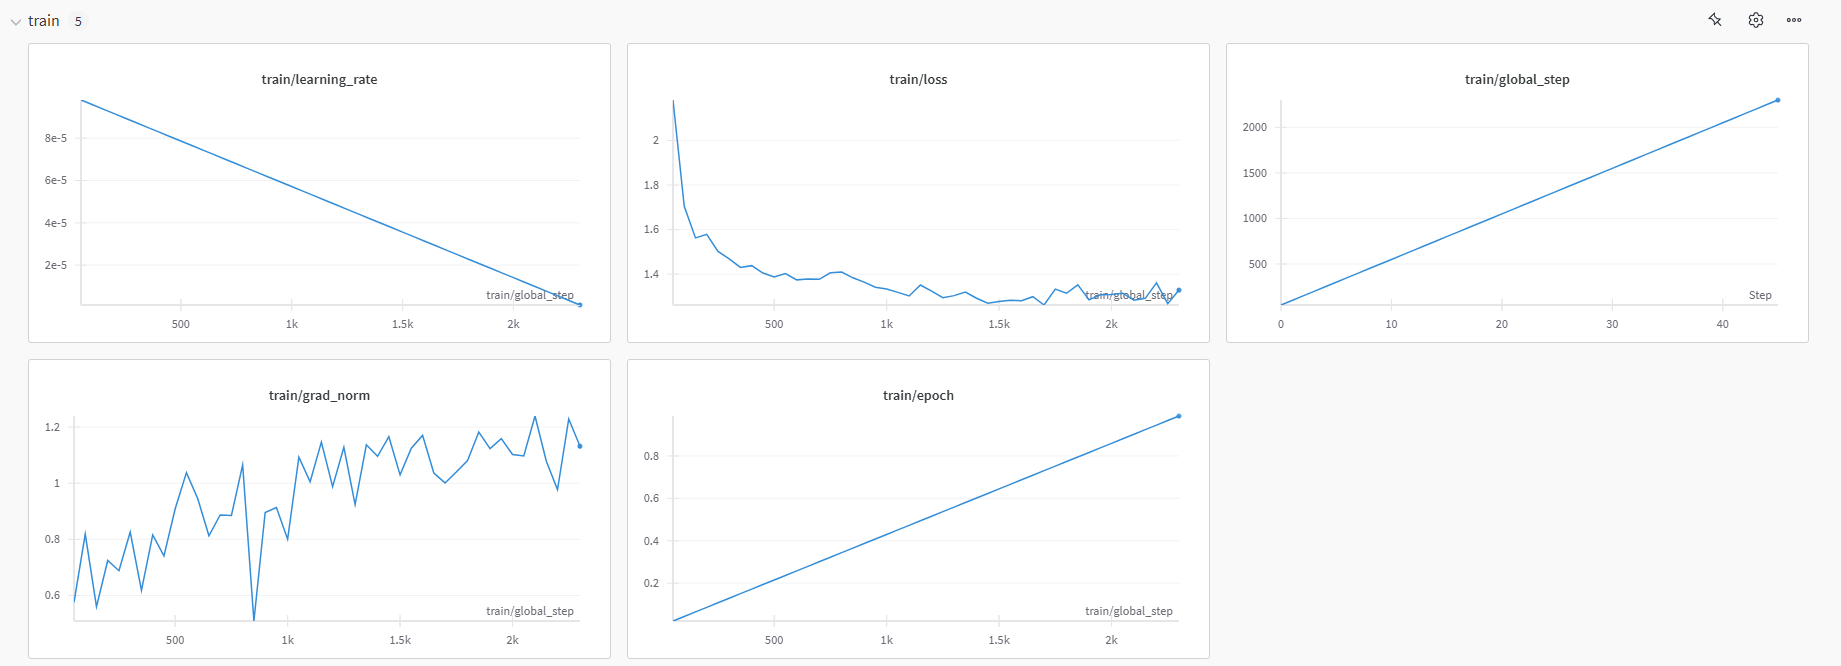

In [14]:
lora_model = trainer.model

In [16]:
new_model = "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/Qwen2.5-0.5B-Python"
trainer.save_model(new_model)

In [17]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        instruction, # instruction
        input, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

lora_model.eval()
with torch.no_grad():
    print(tokenizer.decode(lora_model.generate(**inputs, max_new_tokens=100)[0], skip_special_tokens=True))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Create a function to compute the sum of a list of integers.

### Input:
[1, 2, 3, 4, 5]

### Response:
def sum_list(nums):
    total = 0
    for num in nums:
        total += num
    return total

nums = [1, 2, 3, 4, 5]
print(sum_list(nums)) # Output: 15
